In [1]:
import glob
import os
import random
from skimage import exposure
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

# import keras library
import keras
import tensorflow as tf

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
D_PATH = './trainingData'

In [2]:
# Assemble training and test data from @TrainingData files
data_file = sorted(glob.glob(f'{D_PATH}/*.npy'))
training_dicts=[]
for file in data_file:
    training_files= np.load(file,allow_pickle=True)
    training_dicts.append(training_files[()])

images = []
targets = []
for dict_ in training_dicts:
    for j in range(len(dict_['target'])):
        if dict_['data'][j].shape == (41, 41):
            images.append(dict_['data'][j])
            targets.append(dict_['target'][j])

if len(images) == len(targets):
    X = np.array(images)
    X= X[:,:,:,np.newaxis]
    y = np.array(targets)
    print (f"The Dataset contains {len(X)} images")
else:
    print ("Images and Targets dont match, check the training data!")



The Dataset contains 1329 images


In [3]:
list(y).count(1), list(y).count(0)

(770, 559)

In [4]:
def plot_digits(sample, images_per_row=10, **options):
    size = sample[0].shape[0] # get the size of x,y dimensions
    images_per_row = min(len(sample), images_per_row)
    images=[]
    for image in sample:
        percentiles = np.percentile(image, (1, 99))
        scaled=exposure.rescale_intensity(image, in_range=tuple(percentiles))
        images.append(scaled)
    n_rows = (len(sample) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(sample)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'gray', **options)
    plt.axis("off")
# TODO: change Function to add targets to each image

Saving figure MI_gallery


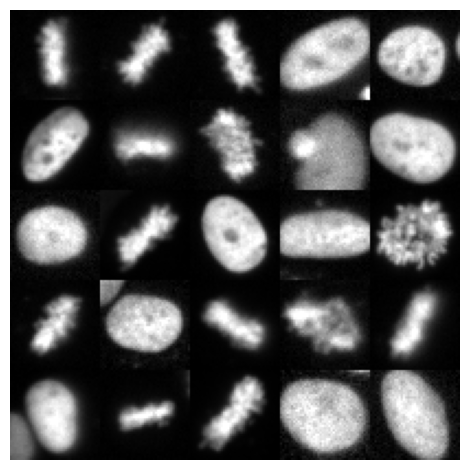

In [5]:
import pathlib
path = pathlib.Path.home() / 'Desktop'
def save_fig(fig_id, path=path, tight_layout=True, fig_extension="pdf", resolution=300):
    dest = path / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(dest, format=fig_extension, dpi=resolution)

sample=random.sample(list(X), 25)
plot_digits(sample, images_per_row=5)
save_fig('MI_gallery')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape


(1063, 41, 41, 1)

In [7]:

# define model as Sequential
model = Sequential()
# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[41,41,1]))
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2,2)))
# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Dropout(0.25))
# add a thirs 2D convolutional layer with 128 filters
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))
# add additional dropout to prevent overfitting
model.add(Dropout(0.5))
# prediction layers
model.add(Dense(1, activation='sigmoid', name='preds'))
# show model summary
model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    )



2023-12-08 10:38:11.603001: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-08 10:38:11.603035: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-08 10:38:11.603048: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-08 10:38:11.603246: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-08 10:38:11.603597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 39, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 19, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 17, 17, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                        

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

# Define a learning rate schedule (custom or predefined)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# # Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Define LearningRateScheduler callback
lr_schedule = LearningRateScheduler(scheduler, verbose=1)

# Compile your model (as you have already done)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Fit your model with these callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    callbacks=[lr_schedule],
    verbose=2,
    validation_split=0.2
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50


2023-12-08 10:38:17.312178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 - 2s - loss: 2617.6038 - accuracy: 0.5776 - val_loss: 245.8873 - val_accuracy: 0.5869 - lr: 0.0010 - 2s/epoch - 70ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
27/27 - 0s - loss: 970.1343 - accuracy: 0.6059 - val_loss: 254.2387 - val_accuracy: 0.9155 - lr: 0.0010 - 440ms/epoch - 16ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
27/27 - 0s - loss: 601.4081 - accuracy: 0.7541 - val_loss: 258.7769 - val_accuracy: 0.9108 - lr: 0.0010 - 430ms/epoch - 16ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
27/27 - 0s - loss: 335.3387 - accuracy: 0.7553 - val_loss: 261.0237 - val_accuracy: 0.8122 - lr: 0.0010 - 429ms/epoch - 16ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/50
27/27 - 0s - loss: 328.6803 - accuracy: 0.7988 - val_loss: 276.9443 - val_accuracy: 0.8592 - lr: 0.0010 - 442ms/epoch 

In [10]:
# import numpy as np
# from sklearn.model_selection import KFold
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# from keras.callbacks import LearningRateScheduler, EarlyStopping
# import tensorflow as tf

# def create_model():
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[41,41,1]))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid', name='preds'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# # Define K-Fold Cross Validation
# num_folds = 5
# kfold = KFold(n_splits=num_folds, shuffle=True)

# fold_no = 1
# for train, test in kfold.split(X_train, y_train):
#     # Define the model
#     model = create_model()
    
#     # Define callbacks
#     lr_schedule = LearningRateScheduler(lambda epoch, lr: lr * tf.math.exp(-0.1) if epoch >= 10 else lr, verbose=1)
#     early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)
    
#     # Fit the model
#     print(f'Training for fold {fold_no} ...')
#     history = model.fit(X_train[train], y_train[train], 
#                         validation_data=(X_train[test], y_train[test]), 
#                         epochs=100, 
#                         callbacks=[lr_schedule, early_stopping], 
#                         verbose=2)
    
#     # Increase the fold number
#     fold_no += 1

In [11]:

# history=model.fit(
#     X_train,
#     y_train,
#     epochs=100,
#     verbose=2,
#     validation_split=0.2)

In [9]:

model.evaluate(X_test,y_test)


9/9 [==============================] - 0s 15ms/step - loss: 56.8976 - accuracy: 0.9624


[56.89762496948242, 0.9624060392379761]

In [10]:
y_proba = model.predict(X_test)

9/9 [==============================] - 0s 7ms/step


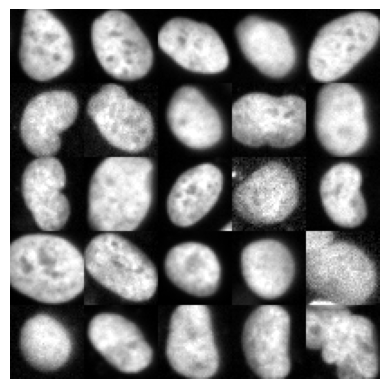

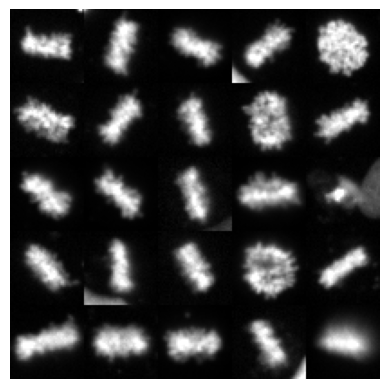

In [11]:
y_proba
# Convert probabilities to class predictions
y_pred = (y_proba > 0.5).astype(int)  # Assuming y_proba is for class 1
# Flatten y_predict to a 1D array
y_predict_flat = y_pred.flatten()

# Find indices for class 0 and class 1
class_0_indices = np.where(y_predict_flat == 0)[0]
class_1_indices = np.where(y_predict_flat == 1)[0]

# Filter X_test using these indices
class_0_images = X_test[class_0_indices, ...]
class_1_images = X_test[class_1_indices, ...]


# Sample and display gallery for Class 0
sample_class_0 = random.sample(list(class_0_images), 25)
plot_digits(sample_class_0, images_per_row=5)
plt.show(block=False)

# Sample and display gallery for Class 1
sample_class_1 = random.sample(list(class_1_images), 25)
plot_digits(sample_class_1, images_per_row=5)

Saving figure training_data


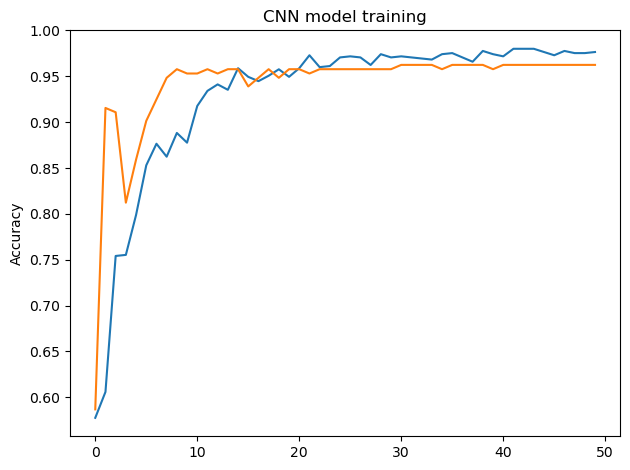

In [12]:
# Extract the history from the training object
training = history.history

# Plot the training loss
plt.plot(training['accuracy'])
# Plot the validation loss
plt.plot(training['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('CNN model training')
save_fig('training_data')
# Show the figure
plt.show()

In [13]:
model.save(os.path.join(D_PATH,'MI_CNN_model20x.h5'))

/Users/hh65/mambaforge/envs/mitotic-release/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:

model1=keras.models.load_model(os.path.join(D_PATH,'MI_CNN_model20x.h5'))

In [15]:

model1.evaluate(X_test,y_test)

9/9 [==============================] - 0s 13ms/step - loss: 56.8976 - accuracy: 0.9624


[56.89762496948242, 0.9624060392379761]

In [16]:
X_test[1].shape

(41, 41, 1)